In [66]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from sklearn.model_selection import train_test_split
# import time
# import math
# from datetime import datetime
# root=''
# try:
#   from google.colab import drive
#   drive.mount('/content/drive')
#   root='./drive/MyDrive/gnn/data/'
# except:
#   pass
# device='cuda' if torch.cuda.is_available() else 'cpu'
# print(torch.cuda.get_device_name(0))
# torch.cuda.empty_cache()

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import time
import math
from datetime import datetime

# 定義資料路徑
root = ''

# # 嘗試掛載 Google Drive
# try:
#     from google.colab import drive
#     drive.mount('/content/drive')
#     root = './drive/MyDrive/gnn/data/'
# except:
#     print("Google Drive not mounted. Proceeding with local path.")

# 檢查設備
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("No CUDA device found. Using CPU.")

# 釋放 CUDA 緩存
torch.cuda.empty_cache()



No CUDA device found. Using CPU.


In [68]:
# filename=root+'data_118_quad/118dc_quad_ISF.txt'
root = 'C:/Users/USER/Desktop/GNN_OPF_electricity_market-main/GNN_OPF_electricity_market-main/GNN_OPF_electricity_market-main/data_gen/118_data/'
# C:\Users\USER\Desktop\GNN_OPF_electricity_market-main\GNN_OPF_electricity_market-main\GNN_OPF_electricity_market-main\data_gen\118_data\118dc_quad_ISF.txt
filename = root + '118dc_quad_ISF.txt'

# import os

# if not os.path.exists(filename):
#     print(f"檔案未找到：{filename}")
# else:
#     print(f"找到檔案：{filename}")

# # 讀取數據
# data = pd.read_csv(filename, sep=',', header=None)
# print("數據形狀:", data.shape)

# ISF 矩陣（186 × 118）：代表節點功率注入對線路功率流的影響。
S_isf=pd.read_table(filename,sep=',',header=None).to_numpy() # ISF matrix
print("S_isf : " ,S_isf.shape)

# 功率流限制（186 × 1）：每條線路的最大功率流限制。
filename=root+'118ac_fmax.txt'
f_max=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit
print("f_max : " ,f_max.shape)

n_line = np.size(S_isf,0)
S = torch.from_numpy(S_isf).to(device) # ISF
f_max = torch.from_numpy(f_max).to(device) # flow limit
print("torch.min(f_max) : " ,torch.min(f_max))

print("====================================")
x=np.load(root+'ac118_p10_x_v.npy')
y=np.load(root+'ac118_p10_y_v.npy')
W=np.load(root+'ac118_p10_w.npy')
print("x : " ,x.shape)
print("y : " ,y.shape)
print("W : " ,W.shape)
print("-----------------\n" ,np.max(x),np.min(x),np.max(y),np.min(y))


# scaling on voltage
vy_deviation = 0.9
vy_scale = 100
y[:,1,:] = (y[:,1,:] - vy_deviation) * vy_scale
print('voltage range(scaled):',np.min(y[:,1,:]),np.max(y[:,1,:]))

# scaling on price
pi_deviation = 0
y[:,0,:] = y[:,0,:] + pi_deviation
# filter out extreme points in price
y_sort_arg = np.argsort(np.amax(np.abs(y[:,0,:]),axis=0)) # max extreme
y_sort_arg1 = np.argsort(np.amin(y[:,0,:],axis=0),axis=0) # min extreme

del_idx0 = []
del_num = 0
for i in range(del_num):
  del_idx0.append(y_sort_arg[-i])
  del_idx0.append(y_sort_arg1[i])
# print(del_idx0)
del_idx = [] # keep only non-repeated
[del_idx.append(x) for x in del_idx0 if x not in del_idx]
del_idx = np.sort(del_idx)
# delete extreme points
print('price range old:',np.min(y[:,0,:]),np.max(y[:,0,:]))
print('voltage range old:',np.min(y[:,1,:]),np.max(y[:,1,:]))
# x = np.delete(x, del_idx, axis=2)
# y = np.delete(y, del_idx, axis=2)
print('price range new:',np.min(y[:,0,:]),np.max(y[:,0,:]))
print('voltage range new:',np.min(y[:,1,:]),np.max(y[:,1,:]))
print(x.shape,y.shape)

S_isf :  (186, 118)
f_max :  (186, 1)
torch.min(f_max) :  tensor(72)
x :  (118, 6, 10000)
y :  (118, 2, 10000)
W :  (118, 118)
-----------------
 1654.8 -332.4 949.67 0.94
voltage range(scaled): 3.9999999999999925 16.000000000000004
price range old: 11.547 949.67
voltage range old: 3.9999999999999925 16.000000000000004
price range new: 11.547 949.67
voltage range new: 3.9999999999999925 16.000000000000004
(118, 6, 10000) (118, 2, 10000)


In [69]:
n_sample=y.shape[-1]
n_bus=y.shape[0]
x_total=x.transpose((1,0,2)).reshape(-1,x.shape[-1])
y_total=y.transpose((1,0,2)).reshape(-1,y.shape[-1])
x_train,x_test,y_train,y_test=train_test_split(x_total.T,y_total.T,test_size=0.2)

# print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
# print("====================================")
# print(x_train)
# print("====================================")
# print(y_train)

# print("====================================")
# x_train	訓練集的輸入特徵	(樣本數, 特徵數)	節點的發電量、發電成本、負載等數據
# x_test	測試集的輸入特徵	(樣本數, 特徵數)	與 x_train 結構相同
# y_train	訓練集的輸出目標	(樣本數, 輸出數)	節點的邊際電價（LMP）、節點電壓等
# y_test	測試集的輸出目標	(樣本數, 輸出數)	與 y_train 結構相同

class Dataset(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x=torch.from_numpy(x).float()
        self.y=torch.from_numpy(y).float()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx=idx.tolist()
        return self.x[idx],self.y[idx]
params={'batch_size': 512,
        'shuffle': True,
        'num_workers': 0}
train=Dataset(x_train,y_train)
train_set=torch.utils.data.DataLoader(train,**params)
val=Dataset(x_test,y_test)
val_set=torch.utils.data.DataLoader(val,**params)

In [70]:
# fig2 = plt.figure(figsize=(8,4))
# flat_list = list(np.concatenate(y[:,n_sample:]).flat)
# flat_list3 = list(np.concatenate(y[:,:n_sample]).flat)
# plt.subplot(1,2,1)
# plt.hist(flat_list,bins = 100,label = 'voltage')
# plt.subplot(1,2,2)
# # plt.hist(flat_list3,range=[-2000, 2000],bins = 100,label = 'price')
# plt.hist(flat_list3,bins = 100,label = 'price')
# plt.show()

In [71]:
# 多層全連接神經網路（FCNN）
class dnn(torch.nn.Module):
  def __init__(self,shape):
    super(dnn,self).__init__()
    layers=[]
    for idx in range(len(shape)-2):
      layers.extend([
        nn.Linear(shape[idx],shape[idx+1]),
        nn.BatchNorm1d(shape[idx+1]),
        nn.ReLU(),
        nn.Dropout(0.5),
      ])
    layers+=[nn.Linear(shape[-2],shape[-1])]
    self.features=nn.Sequential(*layers)
    for temp in self.features:
      if type(temp)==nn.Linear:
        torch.nn.init.normal_(temp.weight,mean=0,std=1)
  def forward(self,x): return self.features(x)
net=dnn([n_bus*6,n_bus*10,n_bus*10,n_bus*10,n_bus*2]).to(device)
print('number of params: %d'%(sum(temp.numel() for temp in net.parameters() if temp.requires_grad)))

number of params: 3909576


In [72]:
# import torch
# import torch.nn as nn
# from torch_geometric.nn import GCNConv  # 使用圖卷積層（Graph Convolutional Layer）

# class GNNNet(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3):
#         super(GNNNet, self).__init__()
#         self.layers = nn.ModuleList()

#         # 第一層圖卷積
#         self.layers.append(GCNConv(input_dim, hidden_dim))

#         # 中間層（隱藏層）
#         for _ in range(num_layers - 2):
#             self.layers.append(GCNConv(hidden_dim, hidden_dim))

#         # 最後一層圖卷積
#         self.layers.append(GCNConv(hidden_dim, output_dim))

#         # Dropout 層（防止過擬合）
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index  # 節點特徵和邊索引

#         # 圖卷積層的前向傳播
#         for layer in self.layers[:-1]:
#             x = layer(x, edge_index)
#             x = torch.relu(x)
#             x = self.dropout(x)

#         # 最後一層卷積
#         x = self.layers[-1](x, edge_index)

#         return x

# # 初始化 GNN 模型
# n_bus_features = 6  # 假設每個節點有 6 個特徵
# hidden_dim = 10 * n_bus  # 隱藏層的節點維度
# output_dim = 2 * n_bus  # 預測輸出的維度

# # 創建圖神經網路模型
# net = GNNNet(input_dim=n_bus_features, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=3).to(device)

# # 打印參數總數
# print('number of params: %d' % (sum(p.numel() for p in net.parameters() if p.requires_grad)))


In [73]:
# threshold function for p_g
# 用於對輸入數據進行雙向閾值（threshold）操作的自訂義神經網路模組
class my_gen_pred_binary(nn.Module):
  def __init__(self):
    super(my_gen_pred_binary,self).__init__()
  def forward(self,x,thresh):
    right_thresh=thresh.clone().detach().requires_grad_(True).double()
    left_thresh=torch.tensor(0).double()
    x=x.double()
    output = torch.sigmoid(left_thresh - x)
    output = torch.mul(output,left_thresh - x) + x
    output = torch.sigmoid(output - right_thresh)
    output = torch.mul(output,output - right_thresh) + right_thresh
    return output

In [74]:
## params needed for S calculation
# line parameters
filename1 = root+'ieee118_lineloc.txt'
filename2 = root+'ieee118_lineparams.txt'
filename3 = root+'ieee118_Bmat.txt'
# incidence info
line_loc = pd.read_table(filename1,sep=',',header=None).to_numpy()
# r, x, shunt, S_max
line_params = pd.read_table(filename2,sep=',',header=None).to_numpy()
B_mat=pd.read_table(filename3,sep=',',header=None).to_numpy()
B_r = np.delete(B_mat,68,axis=0)
B_r = np.delete(B_r,68,axis=1)
Br_inv = np.linalg.inv(B_r)

R_line = line_params[:,0].copy()
X_line = line_params[:,1].copy()

B_shunt = line_params[:,2].copy()

Z_line = R_line + 1j * X_line 
Y_line = 1 / Z_line

G_line = np.real(Y_line)
B_line = np.imag(Y_line)

# transformer indicator
a = (R_line > 0).astype(int)

# params to tensor and GPU
G_line_tensor = torch.from_numpy(G_line).to(device) # conductance
B_line_tensor = torch.from_numpy(B_line).to(device) # susceptance
B_shunt_tensor = torch.from_numpy(B_shunt/2).to(device) # conductance
Br_inv_tensor = torch.from_numpy(Br_inv).to(device) # reduced Bbus matrix
a_tensor = torch.from_numpy(a).double().to(device) # line/transformer

In [75]:
class loss_func:
    def __init__(self,s_max,G_line,B_line,B_shunt,Br_inv,a,line_loc):
      self.s=s_max
      self.g=G_line
      self.b=B_line
      self.c=B_shunt
      self.r=Br_inv
      self.a=a
      self.mse=nn.MSELoss() # MSE loss
      self.lmda1=torch.tensor(10).to(device) # V MSE 
      self.lmda2=torch.tensor(1).to(device) # pi MSE 
      self.lmda3=torch.tensor(0.1).to(device) # v l_inf
      self.lmda4=torch.tensor(0.1).to(device) # s feasibility
      self.lmda5=torch.tensor(0.01).to(device) # pi l_inf
      self.line_loc=line_loc
      self.binary_cell=my_gen_pred_binary()
    def calc(self,pred,label,x,feas):
      mse_p=self.mse(pred[:,:n_bus],label[:,:n_bus])
      mse_v=self.mse(pred[:,n_bus:],label[:,n_bus:])
      linf_p=(pred[:,:n_bus]-label[:,:n_bus]).norm(p=float('inf'))
      linf_v=(pred[:,n_bus:]-label[:,n_bus:]).norm(p=float('inf'))
      if feas==False:
        return self.lmda1*mse_v+self.lmda2*mse_p+self.lmda3*linf_v+self.lmda5*linf_p
      label_pred=pred[:,:n_bus]
      p_max=x[:,:n_bus*1]-x[:,n_bus*1:n_bus*2]
      quadratic_b=x[:,n_bus*4:n_bus*5]
      quadratic_a=x[:,n_bus*5:n_bus*6]
      quadratic_center=(label_pred-quadratic_b)/(quadratic_a+1e-5)/2
      p_inj=self.binary_cell(quadratic_center,p_max)
      bus_inj=p_inj+x[:,n_bus:n_bus*2]
      p_inj_r=torch.cat((bus_inj[:,:68],bus_inj[:,69:]),1)/100
      theta0=torch.matmul(self.r,p_inj_r.T)
      ref_ang=torch.zeros(1,theta0.shape[1]).to(device)
      theta=torch.cat([theta0[:68,:],ref_ang,theta0[68:,:]],0)
      v_pred=(pred[:,n_bus:].transpose(0,1))*0.01+0.9
      
      # s penalty
      theta1=theta[self.line_loc[:,0]-1,:]
      theta2=theta[self.line_loc[:,1]-1,:]
      V1=(v_pred[self.line_loc[:,0]-1,:]).double()
      V2=(v_pred[self.line_loc[:,1]-1,:]).double()
      f_p=(self.a*self.g*(V1*V1).T)-self.a*((V1*V2).T)*(self.g*torch.cos(theta1-theta2).T+self.b*torch.sin(theta1-theta2).T)
      f_p=f_p.T
      f_q=-self.a*(V1.T)*(self.a*V1.T)*(self.b+self.c/2)+self.a*((V1*V2).T)*(self.b*torch.cos(theta1-theta2).T-self.g*torch.sin(theta1-theta2).T)
      f_q=f_q.T
      s_pred=torch.sqrt(f_p*f_p+f_q*f_q+1e-5)*100
      s_penalty=torch.sigmoid(s_pred-self.s)+torch.sigmoid(-s_pred-self.s)
      s_total=torch.sum(s_penalty)

      # sji penalty
      theta1=theta[self.line_loc[:,1]-1,:]
      theta2=theta[self.line_loc[:,0]-1,:]
      V1=(v_pred[self.line_loc[:,1]-1,:]).double()
      V2=(v_pred[self.line_loc[:,0]-1,:]).double() 
      fji_p=(self.a*self.g*(V1*V1).T)-self.a*((V1*V2).T)*(self.g*torch.cos(theta1-theta2).T+self.b*torch.sin(theta1-theta2).T)
      fji_p=fji_p.T
      fji_q=-self.a*(V1.T)*(self.a*V1.T)*(self.b+self.c/2)+self.a*((V1*V2).T)*(self.b*torch.cos(theta1-theta2).T-self.g*torch.sin(theta1-theta2).T)
      fji_q=fji_q.T
      sji_pred=torch.sqrt(fji_p*fji_p+fji_q*fji_q+1e-5)*100
      sji_penalty=torch.sigmoid(sji_pred-self.s)+torch.sigmoid(-sji_pred-self.s)
      sji_total=torch.sum(sji_penalty)

      return self.lmda1*mse_v+self.lmda2*mse_p+self.lmda3*linf_v+self.lmda5*linf_p+self.lmda4*s_total+self.lmda4*sji_total
my_loss=loss_func(f_max,G_line_tensor,B_line_tensor,B_shunt_tensor,Br_inv_tensor,a_tensor,line_loc)

In [76]:
# path=root+'data_118_quad/gnn_trained_ac118.pickle'
# print(path)


# try: 
#   net.load_state_dict(torch.load(path))
#   print('params loaded')
# except: 
#   print('cold start')


optimizer=torch.optim.Adam(net.parameters())
print(optimizer)

train_loss=[]
val_loss=[]

## Training
t0=time.time()
max_epochs=300

eval_epoch=5

# earlystopping
tolerance=5
min_delta=1e-3
previous=0

# add feasibility 
feas=False
for epoch in range(max_epochs):
  
  # training loop
  total_loss=0.0
  for local_batch,local_label in train_set:
    optimizer.zero_grad() # clear the past gradient
    local_batch,local_label=local_batch.to(device),local_label.to(device)
    logits=net(local_batch)
    loss=my_loss.calc(logits,local_label,local_batch,feas)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
  avg_loss=total_loss/len(train_set.dataset)
  train_loss.append(avg_loss)
  print("Epoch %d | Training loss: %.4f"%(epoch,avg_loss))

  # eval 每eval_epoch次評估一次
  if epoch%eval_epoch==0:
    net.eval()
    total_loss=0.0
    for local_batch,local_label in val_set:
      local_batch,local_label=local_batch.to(device),local_label.to(device)
      logits=net(local_batch)
      loss=my_loss.calc(logits,local_label,local_batch,feas)
      total_loss+=loss.item()
    avg_loss=total_loss/len(val_set.dataset)
    val_loss.append([epoch, avg_loss])
    print("Epoch %d | Testing loss: %.4f"%(epoch,avg_loss))
    if epoch:
      if previous-avg_loss<min_delta: tolerance-=1
      if tolerance==0: pass
    previous=avg_loss
    net.train()
t1=time.time()
print("Training time:%.4fs"%(t1-t0))



Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 0 | Training loss: 427.6615
Epoch 0 | Testing loss: 412.2476
Epoch 1 | Training loss: 410.2788
Epoch 2 | Training loss: 394.6954
Epoch 3 | Training loss: 380.2706
Epoch 4 | Training loss: 366.0085
Epoch 5 | Training loss: 351.8826
Epoch 5 | Testing loss: 363.6399
Epoch 6 | Training loss: 337.2040
Epoch 7 | Training loss: 322.4721
Epoch 8 | Training loss: 307.3940
Epoch 9 | Training loss: 292.0530
Epoch 10 | Training loss: 275.9235
Epoch 10 | Testing loss: 301.8994
Epoch 11 | Training loss: 259.7149
Epoch 12 | Training loss: 243.2380
Epoch 13 | Training loss: 226.8216
Epoch 14 | Training loss: 210.4649
Epoch 15 | Training loss: 194.4154
Epoch 15 | Testing loss: 219.6326
Epoch 16 | Training loss: 178.3742
Epoch 17 | Training loss: 162.9887
Epoch 18 | Training loss:

In [77]:
# import torch
# import torch.nn.functional as F
# import time

# # 假設 my_loss.calc() 是自訂的損失函數
# optimizer = torch.optim.Adam(net.parameters())
# print(optimizer)

# train_loss = []
# val_loss = []

# # Training configuration
# t0 = time.time()
# max_epochs = 300
# eval_epoch = 5

# # Early stopping configuration
# tolerance = 15
# min_delta = 1e-4
# previous = 0

# # Feasibility flag
# feas = False

# for epoch in range(max_epochs):
#     # Training loop
#     total_loss = 0.0
#     mse_pi_list = []  # 儲存每個批次的 MSE_pi
#     mse_g_list = []   # 儲存每個批次的 MSE_g

#     for local_batch, local_label in train_set:
#         optimizer.zero_grad()  # Clear the past gradient
#         local_batch, local_label = local_batch.to(device), local_label.to(device)

#         # Forward pass
#         logits = net(local_batch)

#         # Loss calculation
#         loss = my_loss.calc(logits, local_label, local_batch, feas)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#         # Calculate MSE for different targets
#         mse_pi = F.mse_loss(logits, local_label, reduction='mean')
#         mse_g = F.mse_loss(logits, local_label, reduction='mean')  # 假設次目標 MSE 同樣計算
#         mse_pi_list.append(mse_pi.item())
#         mse_g_list.append(mse_g.item())

#     # Calculate average loss and MSE statistics
#     avg_loss = total_loss / len(train_set.dataset)
#     avg_mse_pi = sum(mse_pi_list) / len(mse_pi_list)
#     avg_mse_g = sum(mse_g_list) / len(mse_g_list)
#     std_mse_pi = torch.tensor(mse_pi_list).std().item()
#     std_mse_g = torch.tensor(mse_g_list).std().item()

#     train_loss.append(avg_loss)
#     print(f"Epoch {epoch} | Training loss: {avg_loss:.4f} | MSE_pi: {avg_mse_pi:.4f} | STD_pi: {std_mse_pi:.4e} | MSE_g: {avg_mse_g:.4f} | STD_g: {std_mse_g:.4e}")

#     # Evaluation every eval_epoch epochs
#     if epoch % eval_epoch == 0:
#         net.eval()
#         total_loss = 0.0
#         mse_pi_list = []
#         mse_g_list = []

#         for local_batch, local_label in val_set:
#             local_batch, local_label = local_batch.to(device), local_label.to(device)

#             # Forward pass
#             logits = net(local_batch)

#             # Loss calculation
#             loss = my_loss.calc(logits, local_label, local_batch, feas)
#             total_loss += loss.item()

#             # Calculate MSE
#             mse_pi = F.mse_loss(logits, local_label, reduction='mean')
#             mse_g = F.mse_loss(logits, local_label, reduction='mean')
#             mse_pi_list.append(mse_pi.item())
#             mse_g_list.append(mse_g.item())

#         # Calculate average loss and MSE statistics
#         avg_loss = total_loss / len(val_set.dataset)
#         avg_mse_pi = sum(mse_pi_list) / len(mse_pi_list)
#         avg_mse_g = sum(mse_g_list) / len(mse_g_list)
#         std_mse_pi = torch.tensor(mse_pi_list).std().item()
#         std_mse_g = torch.tensor(mse_g_list).std().item()

#         val_loss.append([epoch, avg_loss])
#         print(f"Epoch {epoch} | Testing loss: {avg_loss:.4f} | MSE_pi: {avg_mse_pi:.4f} | STD_pi: {std_mse_pi:.4e} | MSE_g: {avg_mse_g:.4f} | STD_g: {std_mse_g:.4e}")

#         # Early stopping check
#         if epoch:
#             if previous - avg_loss < min_delta:
#                 tolerance -= 1
#             if tolerance == 0:
#                 print("Early stopping triggered.")
#                 break

#         previous = avg_loss
#         net.train()

# t1 = time.time()
# print(f"Training time: {t1 - t0:.4f}s")


In [78]:
timestamp=datetime.now().strftime('%m%d%H%M')

path=root+'model/dnn_%s.pickle'%(timestamp)

if feas==False: path.replace('feas','')
print(path)
torch.save(net.state_dict(),path)

C:/Users/USER/Desktop/GNN_OPF_electricity_market-main/GNN_OPF_electricity_market-main/GNN_OPF_electricity_market-main/data_gen/118_data/model/dnn_02092216.pickle


Training loss: 300
[427.66146875, 410.27880859375, 394.69540625, 380.27056640625, 366.008517578125, 351.88259765625, 337.2039921875, 322.472083984375, 307.39401953125, 292.05301171875, 275.923498046875, 259.7148515625, 243.2379794921875, 226.8215888671875, 210.464935546875, 194.4154267578125, 178.3741904296875, 162.9886728515625, 148.6872880859375, 134.899107421875, 122.041619140625, 110.3643759765625, 99.4624775390625, 89.91789599609375, 81.32284912109375, 73.87091357421875, 67.30602270507812, 61.75845434570312, 56.89147631835937, 52.66504272460938, 49.36939721679688, 46.372134765625, 43.85220629882812, 41.855541748046875, 39.96818505859375, 38.3388193359375, 36.862109619140625, 35.52890454101563, 34.359335205078125, 33.294887451171874, 32.287814697265624, 31.505720458984374, 30.522907958984376, 29.677668212890627, 28.837216186523438, 28.26524755859375, 27.476775146484375, 26.775524536132814, 26.048110595703125, 25.467942749023436, 24.916290405273436, 24.244539306640625, 23.6465240478

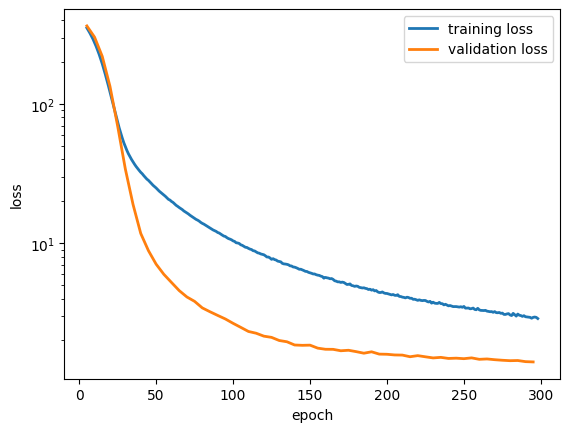

In [79]:
print('Training loss:', len(train_loss))
print(train_loss)
print('Validation loss:', len(val_loss))
print(val_loss)

val_len = len(val_loss)
print(val_len)
val_plt = np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i] = val_loss[i][0]
  val_plt[1,i] = val_loss[i][1]

plt.figure()
plot_idx = np.arange(np.size(train_loss))
plt.plot(plot_idx[5:-1],train_loss[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

Training loss: 300
[427.66146875, 410.27880859375, 394.69540625, 380.27056640625, 366.008517578125, 351.88259765625, 337.2039921875, 322.472083984375, 307.39401953125, 292.05301171875, 275.923498046875, 259.7148515625, 243.2379794921875, 226.8215888671875, 210.464935546875, 194.4154267578125, 178.3741904296875, 162.9886728515625, 148.6872880859375, 134.899107421875, 122.041619140625, 110.3643759765625, 99.4624775390625, 89.91789599609375, 81.32284912109375, 73.87091357421875, 67.30602270507812, 61.75845434570312, 56.89147631835937, 52.66504272460938, 49.36939721679688, 46.372134765625, 43.85220629882812, 41.855541748046875, 39.96818505859375, 38.3388193359375, 36.862109619140625, 35.52890454101563, 34.359335205078125, 33.294887451171874, 32.287814697265624, 31.505720458984374, 30.522907958984376, 29.677668212890627, 28.837216186523438, 28.26524755859375, 27.476775146484375, 26.775524536132814, 26.048110595703125, 25.467942749023436, 24.916290405273436, 24.244539306640625, 23.6465240478

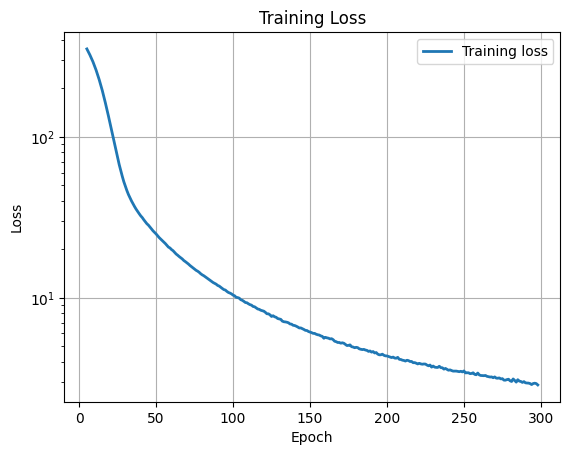

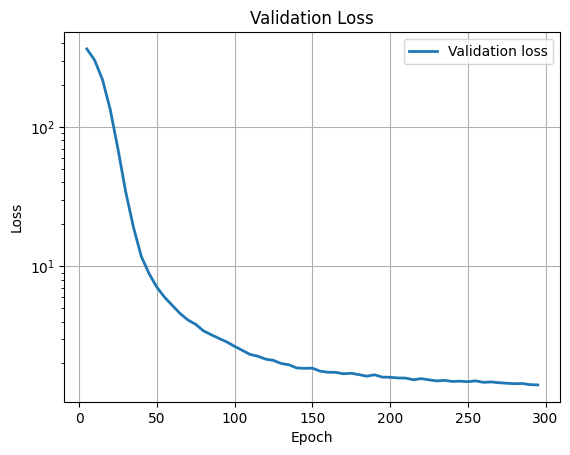

In [80]:
print('Training loss:', len(train_loss))
print(train_loss)
print('Validation loss:', len(val_loss))
print(val_loss)


# 準備驗證損失數據
val_len = len(val_loss)
val_plt = np.zeros((2, val_len))
for i in range(val_len):
    val_plt[0, i] = val_loss[i][0]
    val_plt[1, i] = val_loss[i][1]

# **圖1：訓練損失圖**
plot_idx = np.arange(np.size(train_loss))
plt.plot(plot_idx[5:-1], train_loss[5:-1], lw=2, label='Training loss')
plt.yscale("log")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show(block=False)

# **圖2：驗證損失圖**
plt.plot(val_plt[0, 1:], val_plt[1, 1:], lw=2, label='Validation loss')
plt.yscale("log")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.show(block=False)


# Evaluate the model w/ validation set

In [81]:
n_test = np.size(x_test,0)
x_test_feed = torch.from_numpy(x_test).float()
x_test_feed = x_test_feed#.transpose(1,2)
x_test_feed = x_test_feed.to(device)

# 輸入特徵 x_test_feed
# 預測結果 y_pred {價格（LMP，邊際電價）, 電壓}


print('Validation dataset size:',x_test_feed.shape)
print('Number of validation set: ',n_test)
y_pred = net(x_test_feed)
print(y_pred.shape)

print('n_test:',n_test)
print('x_test_feed:',x_test_feed)
print('y_pred:',y_pred)

Validation dataset size: torch.Size([2000, 708])
Number of validation set:  2000
torch.Size([2000, 236])
n_test: 2000
x_test_feed: tensor([[-60.3460, -19.1990, -42.8370,  ...,   0.0000,   0.0000,   0.0000],
        [-49.0070, -17.7430, -42.2490,  ...,   0.0000,   0.0000,   0.0000],
        [-45.7590, -19.8600, -45.5030,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [-61.0100, -22.4410, -37.7130,  ...,   0.0000,   0.0000,   0.0000],
        [-52.7840, -20.4220, -45.5780,  ...,   0.0000,   0.0000,   0.0000],
        [-49.0600, -19.1160, -34.8530,  ...,   0.0000,   0.0000,   0.0000]])
y_pred: tensor([[446.1416, 425.0415, 471.5704,  ...,   8.3436,  12.8755,  11.1563],
        [510.9260, 530.1897, 486.0212,  ...,  14.7717,  13.5473,  13.7591],
        [557.5089, 582.4094, 584.6072,  ...,  15.8225,  15.1222,  13.4337],
        ...,
        [456.2439, 490.1826, 473.0164,  ...,  14.2820,  10.9729,   9.7830],
        [363.4962, 386.7236, 401.3207,  ...,  11.5674,  13.1692,   8.3968]

* Visualization




 - Visualize errors

In [82]:
y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy()#.transpose()
print(y_test.shape,y_pred1.shape)

#y_pred：模型預測的輸出。
#y_pred1：將預測結果移回 CPU 並轉換為 NumPy 格式。

(2000, 236) (2000, 236)


In [83]:
# x=np.reshape(x,(x.shape[0]*x.shape[1],x.shape[2])) # reshape by samples not dim1
# y=np.reshape(y,(y.shape[0]*y.shape[1],y.shape[2]))
# print(x_pre.shape,y_pre.shape)

y_pred_temp = y_pred1.copy().transpose()
# y_pred2=np.reshape(y_pred2,(y_pre.shape[0],y_pre.shape[1],n_test))
y_pred2=np.zeros([y.shape[0],y.shape[1],n_test])
y_pred2[:,0,:]=y_pred_temp[:n_bus,:]
y_pred2[:,1,:]=y_pred_temp[n_bus:,:]
print(y_pred2.shape,y_pred1.shape)

y_test_temp = y_test.copy().transpose()
# y_pred2=np.reshape(y_pred2,(y_pre.shape[0],y_pre.shape[1],n_test))
y_test2=np.zeros([y.shape[0],y.shape[1],n_test])
y_test2[:,0,:]=y_test_temp[:n_bus,:]
y_test2[:,1,:]=y_test_temp[n_bus:,:]
y_pred1 = y_pred2.copy()

(118, 2, 2000) (2000, 236)


In [84]:
# recover the original p.u. scale
# vy_deviation) * vy_scale
#模型輸出的電壓可能被縮放過，因此在這裡將其還原至原始比例。
y_pred1[:,1,:] = y_pred1[:,1,:] / vy_scale + vy_deviation
y_test2[:,1,:] = y_test2[:,1,:] / vy_scale + vy_deviation
print(y_test2.shape,y_pred1.shape)

(118, 2, 2000) (118, 2, 2000)


In [85]:
#L2 錯誤：計算預測與真實值之間的 L2 範數誤差。
#L∞ 錯誤：計算最大絕對誤差（L∞ 範數）
n_test = np.size(y_test2,2)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_test2[:,0,i] - y_pred1[:,0,i]) / np.linalg.norm(y_test2[:,0,i])
  err_Linf[i] = np.max(np.abs(y_test2[:,0,i] - y_pred1[:,0,i])) / np.max(np.abs(y_test2[:,0,i]))

err_L2_v = np.zeros(n_test)
err_Linf_v = np.zeros(n_test)
for i in range(n_test):
  err_L2_v[i] = np.linalg.norm(y_test2[:,1,i] - y_pred1[:,1,i]) / np.linalg.norm(y_test2[:,1,i])
  err_Linf_v[i] = np.max(np.abs(y_test2[:,1,i] - y_pred1[:,1,i])) / np.max(np.abs(y_test2[:,1,i]))

Price L2 mean: 0.07903785831626332 L_inf mean: 0.12254581125787056
Voltage L2 mean: 0.02109210574351279 L_inf mean: 0.0639735336917768


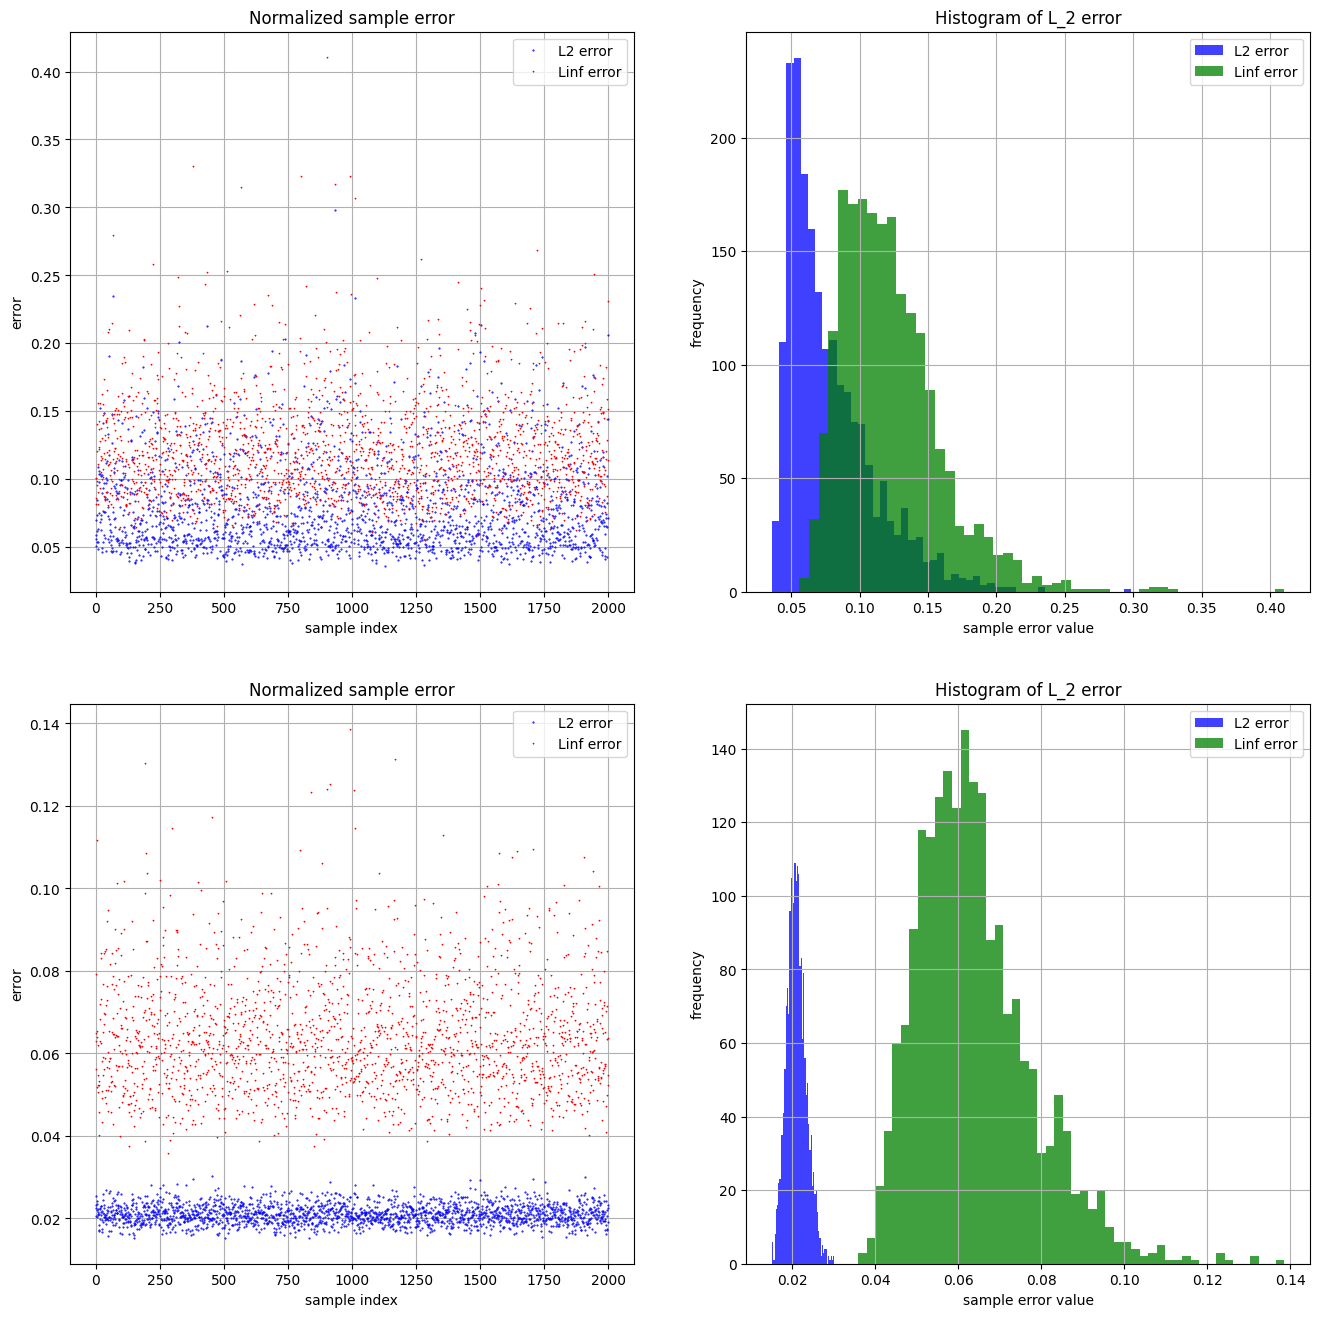

In [86]:
#計算並輸出 L2 和 L∞ 錯誤的平均值。
err_L2_mean = np.mean(err_L2)
err_Linf_mean = np.mean(err_Linf)
print('Price L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )
err_L2_mean_v = np.mean(err_L2_v)
err_Linf_mean_v = np.mean(err_Linf_v)
print('Voltage L2 mean:', err_L2_mean_v,'L_inf mean:', err_Linf_mean_v )

fig2 = plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(2, 2, 2)
plt.hist(err_L2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)

plt.subplot(2, 2, 3)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2_v,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf_v,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(2, 2, 4)
plt.hist(err_L2_v, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf_v, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [87]:
print(y_pred1[:,1,:n_test].shape,y_test2[:,1,:n_test].shape)
print('true range:',np.max(y_test2[:,1,:n_test]),np.min(y_test2[:,1,:n_test]))
print('predicted range',np.max(y_pred1[:,1,:n_test]),np.min(y_pred1[:,1,:n_test]))

# fig3 = plt.figure(figsize=(16, 8))
# flat_list1 = list(np.concatenate(y_test2[:,1,:n_test]).flat)
# flat_list2 = list(np.concatenate(y_pred1[:,1,:n_test]).flat)
# plt.hist(flat_list1,bins = 100,label = 'true')

# plt.hist(flat_list2,bins = 100,label = 'pred')
# plt.legend(loc="upper right")
# plt.grid(True)
# plt.show()

(118, 2000) (118, 2000)
true range: 1.06 0.94
predicted range 1.194318504333496 0.8639387607574464


In [90]:
print(x.shape,n_sample)

#重新組織輸入和輸出數據，使其形狀符合需求（可能針對多個節點或變數）。
x_new = np.zeros([x.shape[0],x.shape[1],n_sample])
for i in range(x.shape[1]):
  x_new[:,i,:] = x_total[n_bus*i:n_bus*(i+1),:]

y_new = np.zeros([y.shape[0],y.shape[1],n_sample])
for i in range(y.shape[1]):
  y_new[:,i,:] = y_total[n_bus*i:n_bus*(i+1),:]

(118, 6, 10000) 10000


In [ ]:
# MSE𝜋（電價的均方誤差）
mse_pi_1 = np.mean((y_test2[:, 0, :] - y_pred1[:, 0, :]) ** 2)
# mse_pi_2 = torch.nn.functional.mse_loss(torch.tensor(y_test2[:, 0, :]), torch.tensor(y_pred1[:, 0, :]))
#  STD𝜋 （電價的標準差）
std_pi = np.std(y_test2[:, 0, :] - y_pred1[:, 0, :])


#MSE𝑔（功率流的均方誤差）
mse_g = np.mean((y_test2[:, 1, :] - y_pred1[:, 1, :]) ** 2)

# Feasibility（可行性）
flow_limit = 1.0  # 假設功率流限制
violations = (y_pred1[:, 1, :] > flow_limit).sum()
feasibility = 1 - (violations / y_pred1[:, 1, :].size)
print('Feasibility:', feasibility)

#Parameters（參數數量）
parameter_count = sum(p.numel() for p in net.parameters())

#MSE𝑣（電壓的均方誤差）
mse_v = np.mean((y_test2[:, 1, :] - y_pred1[:, 1, :]) ** 2)

#STD𝑣（電壓的標準差）
std_v = np.std(y_test2[:, 1, :] - y_pred1[:, 1, :])

results = {
    'Case': ['118-ac'],
    'Model': ['NN'],
    'MSE_pi_1': [mse_pi_1],
    'STD_pi': [std_pi],
    'MSE_g': [mse_g],
    'Feasibility': [feasibility],
    'Parameters': [parameter_count],
    'MSE_v': [mse_v],
    'STD_v': [std_v],
}

df_results = pd.DataFrame(results)
print(df_results)


Feasibility: 0.16682203389830508
     Case Model     MSE_pi_1                                MSE_pi_2  \
0  118-ac    NN  1471.835942  tensor(1471.8359, dtype=torch.float64)   

     STD_pi     MSE_g  Feasibility  Parameters     MSE_v     STD_v  
0  38.32502  0.000476     0.166822     3909576  0.000476  0.021811  


# Predict generation using $\pi$
* Using predicted $\pi$ and find the active constraints in $p_G(i)$
* For inactive $p_G(i)$ consider other methods like power flow balance

In [24]:
gen_limit0 = x_new[:,4,:].copy() # lin cost
print(gen_limit0.shape)

gen_idx = []
gen_idx = np.arange(n_bus)
# for i in range(n_bus):
#   if gen_limit0[i,0] > 0:
#     gen_idx.append(i)
print(type(gen_idx),len(gen_idx),gen_idx)

(118, 10000)
<class 'numpy.ndarray'> 118 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117]


In [ ]:
n_sample=x_total.shape[-1]
x_feed = torch.from_numpy(x_total.T).float()
y_pred1=net(x_feed.to(device)).cpu().detach().numpy().T
y_pred_temp = y_pred1.copy()
y_pred2=np.zeros([y.shape[0],y.shape[1],n_sample])
y_pred2[:,0,:]=y_pred_temp[:n_bus,:]
y_pred2[:,1,:]=y_pred_temp[n_bus:,:]
print(y_pred2.shape,y_pred1.shape)
y_pred1 = y_pred2.copy()

(118, 2, 10000) (236, 10000)


In [ ]:
gen_cost0 = x_new[:,4,:].copy()
lmp_data = y_new[:,0,:].copy()
quadratic_a = x_new[:,5,:].copy()
profit_pred = y_pred1[:,0,:] - gen_cost0
print(np.min(np.abs(profit_pred)))
profit_true = lmp_data - gen_cost0
print(np.min(np.abs(profit_true)))
profit_pred=(y_pred1[:,0,:]-gen_cost0)/(quadratic_a+1e-10)/2
profit_true=(lmp_data-gen_cost0)/(quadratic_a+1e-10)/2
print(np.min(np.abs(profit_pred)))
print(np.min(np.abs(profit_true)))

0.0001266326904296733
0.784000000000006
0.04521626843762751
0.24221453285700786


In [ ]:
print(profit_pred.shape,profit_true.shape)
profit_err = profit_true - profit_pred
profit_err_l2 = np.zeros([n_sample,1])

for i in range(n_sample):
  profit_err_l2[i] = np.linalg.norm(profit_err[:,i])/np.linalg.norm(profit_true[:,i])
print(np.mean(profit_err_l2))

# fig5 = plt.figure(figsize=(16, 8))
# # error histogram
# plt.hist(profit_err_l2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
# # plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
# plt.legend(loc="upper right")
# plt.xlabel('sample error value')
# plt.ylabel('frequency')
# plt.title('Histogram of L_2 error')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)
# plt.show()

(118, 10000) (118, 10000)
0.07720249022373613


In [28]:
p_pred_sort = np.reshape(profit_pred,n_bus*n_sample)
p_true_sort = np.reshape(profit_true,n_bus*n_sample)
print(p_pred_sort.shape)
print(np.min(p_pred_sort),np.min(p_true_sort))

(1180000,)
-3990.874236701537 -2.9391182643149665


In [29]:
# fig2 = plt.figure(figsize=(8, 8))
# plt.hist(p_pred_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. profit')
# plt.hist(p_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true profit')
# plt.legend(loc="upper right")
# plt.xlabel('value')
# plt.ylabel('frequency')
# plt.title('profit histogram')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)
# plt.show()

In [ ]:
# x = [load, gen_cost, gen_lim]
binary_thres_true = 1e-5
binary_thres = x_new[:,0,:].copy() # upper
binary_thres_lo = x_new[:,1,:].copy() # lower
gen_pred_binary_full = np.zeros((n_bus,n_sample))
gen_true_binary_full = np.zeros((n_bus,n_sample))

for i in range(n_sample):
  for j in range(len(gen_idx)):
    # predicted generator limit
    if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_pred[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
    # true generator limit
    if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_true[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]

gen_inj=gen_pred_binary_full
gen_inj_true=gen_true_binary_full
# nodal injection
load0 = -x_new[:,1,:].copy() # load file
p_inj = gen_inj #- load0
p_inj_true = gen_inj_true #- load0
print(np.sum(p_inj),np.sum(gen_inj_true))
print(np.sum(p_inj),np.sum(load0),np.sum(gen_inj))

1878765.2000831843 2764601.835122853
1878765.2000831843 43260060.56350001 1878765.2000831843


## injection accuracy

In [ ]:
print(p_inj_true.shape,p_inj.shape)
p_inj_true_sort = np.reshape(p_inj_true,n_bus*n_sample)
p_inj_sort = np.reshape(p_inj,n_bus*n_sample)
p_err = np.zeros(n_sample)
for i in range(n_sample):
  p_err[i] = np.linalg.norm(p_inj_true[:,i]-p_inj[:,i]) / np.linalg.norm(p_inj_true[:,i])
print('mean p_inj l2 err:',np.mean(p_err))
# fig3 = plt.figure(figsize=(16, 8))
# plt.subplot(1,2,1)
# plt.hist(p_inj_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. injection')
# plt.hist(p_inj_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true injection')
# plt.legend(loc="upper right")
# plt.xlabel('value')
# plt.ylabel('frequency')
# plt.title('injection histogram')
# plt.subplot(1,2,2)
# plt.hist(p_err, bins = 50, facecolor='b', alpha=0.75,label = 'injection err')
# plt.legend(loc="upper right")
# plt.xlabel('value')
# plt.ylabel('frequency')
# plt.title('error histogram')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)s_binary
# plt.show()

(118, 10000) (118, 10000)
mean p_inj l2 err: 0.1709061086967419


* Calculate flow

In [ ]:
filename=root+'118ac_fmax.txt'
f_max1=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit

n_line = np.size(S_isf,0)
flow_est = np.zeros((n_line,n_sample))
flow_est0 = np.zeros((n_line,n_sample))

f_binary = np.zeros((n_line,n_sample))
f_binary0 = np.zeros((n_line,n_sample))

# for i in range(n_sample):
flow_est = np.dot(S_isf,p_inj)
flow_est0 = np.dot(S_isf,p_inj_true)
# f_max
# f_max_numpy = f_max.cpu().detach().numpy()
f_max_numpy = f_max1.copy()
f_binary = (np.abs(flow_est)-f_max_numpy > 0)
f_binary0 = (np.abs(flow_est0)-f_max_numpy > 0)

print(f_max_numpy.shape,flow_est.shape,flow_est0.shape)
f_tot_sample = n_line * n_sample
print(np.sum(f_binary),np.sum(f_binary0))
print(np.sum(f_binary)/f_tot_sample,np.sum(f_binary0)/f_tot_sample)
print(n_line,n_sample,flow_est.shape)

(186, 1) (186, 10000) (186, 10000)
18979 13334
0.010203763440860216 0.007168817204301075
186 10000 (186, 10000)


In [ ]:
# soft threshold
f_err_est = np.abs(flow_est)-f_max_numpy
f_err_true = np.abs(flow_est0)-f_max_numpy

f_err_est = np.maximum(np.abs(flow_est)-f_max_numpy,0) # identify violations
f_err_true = np.maximum(np.abs(flow_est0)-f_max_numpy,0)

print(np.max(f_err_est),np.max(f_err_true))
print(np.max(f_err_est/f_max_numpy),np.max(f_err_true/f_max_numpy))

184.0412874052102 39.64401431411352
1.2269419160347346 0.2642934287607568


In [ ]:
f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.1*(f_max_numpy))
f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.1*(f_max_numpy))
print(np.sum(f_binary_soft),np.sum(f_binary0_soft))
print(np.sum(f_binary_soft)/f_tot_sample,np.sum(f_binary0_soft)/f_tot_sample)

14568 10451
0.007832258064516128 0.005618817204301075


In [35]:
f_pred_sort = np.reshape(f_err_est/f_max_numpy,n_line*n_sample)
f_true_sort = np.reshape(f_err_true/f_max_numpy,n_line*n_sample)

# fig2 = plt.figure(figsize=(16, 8))
# plt.subplot(1,2,1)
# plt.hist(f_pred_sort, bins = 10, facecolor='b', alpha=0.75,label = 'pred. f')
# plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
# plt.legend(loc="upper right")
# plt.xlabel('percentage')
# plt.ylabel('frequency')
# plt.title('flow violation level histogram')
# plt.subplot(1,2,2)
# plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
# plt.legend(loc="upper right")
# plt.xlabel('percentage')
# plt.ylabel('frequency')
# plt.title('flow violation level histogram')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)
# plt.show()

In [36]:
f_line = np.sum(f_binary,0)
f_samp = np.sum(f_binary,1)
print('max sample pred:',np.max(f_line))
print('max line pred:',np.max(f_samp))

f_line0  = np.sum(f_binary0,0)
f_samp0 = np.sum(f_binary0,1)
print('max sample true:',np.max(f_line0))
print('max line true:',np.max(f_samp0))

max sample pred: 7
max line pred: 7261
max sample true: 3
max line true: 10000


# Check objective optimality

In [ ]:
gen_cost_pred = np.zeros((n_bus,n_sample))
gen_cost_true = np.zeros((n_bus,n_sample))
objective_err = np.zeros(n_sample)

gen_cost_pred = np.multiply(np.multiply(p_inj,p_inj),quadratic_a) + np.multiply(p_inj,gen_cost0)
gen_cost_true = np.multiply(np.multiply(p_inj_true,p_inj_true),quadratic_a) + np.multiply(p_inj_true,gen_cost0)

objective_err = np.sum(np.abs(gen_cost_true-gen_cost_pred),axis=0) / np.sum(gen_cost_true,axis=0)
print(np.mean(objective_err))

# fig6 = plt.figure(figsize=(16, 8))
# # error histogram
# plt.hist(objective_err, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
# # plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
# plt.legend(loc="upper right")
# plt.xlabel('sample error value')
# plt.ylabel('frequency')
# plt.title('Histogram of L_2 error')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)
# plt.show()

0.1241495759948697


## injection accuracy

In [ ]:
print(p_inj_true.shape,p_inj.shape)

p_inj_true_sort = np.reshape(p_inj_true,n_bus*n_sample)
p_inj_sort = np.reshape(p_inj,n_bus*n_sample)

p_err = np.zeros(n_sample)
for i in range(n_sample):
  p_err[i] = np.linalg.norm(p_inj_true[:,i]-p_inj[:,i]) / np.linalg.norm(p_inj_true[:,i])

print('mean p_inj l2 err:',np.mean(p_err))
# fig3 = plt.figure(figsize=(16, 8))
# plt.subplot(1,2,1)
# plt.hist(p_inj_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. injection')
# plt.hist(p_inj_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true injection')
# plt.legend(loc="upper right")
# plt.xlabel('value')
# plt.ylabel('frequency')
# plt.title('injection histogram')s_binary
# plt.subplot(1,2,2)
# plt.hist(p_err, bins = 50, facecolor='b', alpha=0.75,label = 'injection err')
# plt.legend(loc="upper right")
# plt.xlabel('value')
# plt.ylabel('frequency')
# plt.title('error histogram')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.grid(True)
# plt.show()

(118, 10000) (118, 10000)
mean p_inj l2 err: 0.1709061086967419


# Test AC feasibility
* P in actual value, V in p.u.
* Use P to recover $\theta$, or solve $\theta$ and Q for PF
$$ Q_m = V_m \sum_{n=1}^N V_n \left(G_{mn}\sin\theta_{mn} - B_{mn}\cos\theta_{mn} \right) $$
calculate $Q_{mn}$ directly

In [ ]:
# Bbus and B_r inverse
filename1 = root+'ieee118_Bbus.txt'
Bbus=pd.read_table(filename1,sep=',',header=None).to_numpy()
B_r = np.delete(Bbus,68,axis=0)
B_r = np.delete(B_r,68,axis=1)
Br_inv = np.linalg.inv(B_r)

# Y = G + jB
filename1 = root+'ieee118_Gmat.txt'
G_mat=pd.read_table(filename1,sep=',',header=None).to_numpy()
filename1 = root+'ieee118_Bmat.txt'
B_mat=pd.read_table(filename1,sep=',',header=None).to_numpy()
print(G_mat.shape,B_mat.shape)

# line parameters
filename1 = root+'ieee118_lineloc.txt'
line_loc = pd.read_table(filename1,sep=',',header=None).to_numpy()

# load line params
filename1 = root+'ieee118_lineparams.txt'
line_params = pd.read_table(filename1,sep=',',header=None).to_numpy()
R_line = line_params[:,0].copy()
X_line = line_params[:,1].copy()
B_shunt = line_params[:,2].copy()
Z_line = R_line + 1j * X_line 
Y_line = 1 / Z_line
G_line = np.real(Y_line)
B_line = np.imag(Y_line)
# P_inj w/out reference bus in p.u.
p_inj_r = np.delete(p_inj,68,axis=0) / 100
p_inj_true_r = np.delete(p_inj_true,68,axis=0) / 100
p_inj_pu = p_inj / 100
p_inj_true_pu = p_inj_true / 100
print(Br_inv.shape,p_inj.shape,p_inj_true.shape)#p_inj_true

theta0 = np.matmul(Br_inv,p_inj_r)
theta_true0 = np.matmul(Br_inv,p_inj_true_r)
theta = np.insert(theta0,68,0,axis = 0)
theta_true = np.insert(theta_true0,68,0,axis = 0)
print(theta.shape,theta_true.shape)

(118, 118) (118, 118)
(117, 117) (118, 10000) (118, 10000)
(118, 10000) (118, 10000)


In [40]:
print(np.max(theta),np.min(theta))
math.sin(math.pi/6)
print(G_line[0],B_line[0])

0.47132580038792565 -0.9976958766345078
2.7803011534120627 -9.166735486002148


In [ ]:
# Calculate real and reactive flow
f_p = np.zeros((n_line,n_sample))
f_q = np.zeros((n_line,n_sample))
fji_p = np.zeros((n_line,n_sample))
fji_q = np.zeros((n_line,n_sample))
print(f_q.shape)

v_pred = y_pred1[:,1,:].copy()
v_pred = v_pred / vy_scale + vy_deviation
print(np.max(v_pred),np.min(v_pred),v_pred.shape)

theta1 = theta[line_loc[:,0]-1,:]
theta2 = theta[line_loc[:,1]-1,:]
V1 = v_pred[line_loc[:,0]-1,:]
V2 = v_pred[line_loc[:,1]-1,:] 
f_p=(a*G_line*(V1*V1).T)-a*((V1*V2).T)*(G_line*np.cos(theta1-theta2).T+B_line*np.sin(theta1-theta2).T)
f_p=f_p.T
f_q=-a*(V1.T)*(a*V1.T)*(B_line+B_shunt/2)+a*((V1*V2).T)*(B_line*np.cos(theta1-theta2).T-G_line*np.sin(theta1-theta2).T)
f_q=f_q.T

theta1 = theta[line_loc[:,1]-1,:]
theta2 = theta[line_loc[:,0]-1,:]
V1 = v_pred[line_loc[:,1]-1,:]
V2 = v_pred[line_loc[:,0]-1,:]
fji_p=(a*G_line*(V1*V1).T)-a*((V1*V2).T)*(G_line*np.cos(theta1-theta2).T+B_line*np.sin(theta1-theta2).T)
fji_p=fji_p.T
fji_q=-a*(V1.T)*(a*V1.T)*(B_line+B_shunt/2)+a*((V1*V2).T)*(B_line*np.cos(theta1-theta2).T-G_line*np.sin(theta1-theta2).T)
fji_q=fji_q.T

(186, 10000)
1.184106330871582 0.8248611354827882 (118, 10000)


In [ ]:
s_pred = np.sqrt(f_p*f_p+f_q*f_q)*100
sji_pred = np.sqrt(fji_p*fji_p+fji_q*fji_q)*100
print(np.max(f_q),np.min(f_q))
flow_est.shape
print(np.mean(s_pred[0,:]),np.mean(f_max_numpy[0]))

26.030427497894152 -29.671874401177945
35.07514169527088 151.0


In [ ]:
sij_binary = (np.abs(s_pred)-f_max_numpy[:n_line] > 0)
sji_binary = (np.abs(sji_pred)-f_max_numpy[:n_line] > 0)
s_binary = np.maximum(sij_binary,sji_binary)
print(np.sum(s_binary))#,np.sum(f_binary0))
print('hard violation rate:',np.sum(s_binary)/n_sample/n_line)#,np.sum(f_binary0)/f_tot_sample)
s_binary_soft = (np.abs(s_pred)-f_max_numpy[:n_line] > 0.1*(f_max_numpy[:n_line]))
print(np.sum(s_binary_soft))#,np.sum(f_binary0_soft))
print(np.sum(s_binary_soft)/n_sample/n_line)#,np.sum(f_binary0_soft)/f_tot_sample)

102142
hard violation rate: 0.05491505376344086
79802
0.04290430107526882


In [ ]:
# violation level
sij_violation = np.abs(s_pred)-f_max_numpy[:n_line] #/ f_max_numpy
sij_violation_level = np.maximum(sij_violation,0)
sji_violation = np.abs(sji_pred)-f_max_numpy[:n_line] #/ f_max_numpy
sji_violation_level = np.maximum(sji_violation,0)
s_violation_level = np.maximum(sij_violation_level,sji_violation_level)
s_violation_level = np.divide(s_violation_level,f_max_numpy[:n_line])
s_vio_lvl = np.reshape(s_violation_level,n_line*n_sample)

print('S violation level:')
print('hard:',np.sum(s_binary)/f_tot_sample)
print('mean:',np.mean(s_vio_lvl))
print('median:',np.median(s_vio_lvl))
print('max:',np.max(s_vio_lvl))
print('std:',np.std(s_vio_lvl))
print('p99:',np.percentile(s_vio_lvl,99))

f_violation = np.abs(flow_est)-f_max_numpy #/ f_max_numpy
f_violation_level = np.maximum(f_violation,0)
f_violation_level = np.divide(f_violation_level,f_max_numpy)
f_vio_lvl = np.reshape(f_violation_level,n_line*n_sample)

print('f violation level:')
print('hard:',np.sum(f_binary)/f_tot_sample,np.sum(f_binary0)/f_tot_sample)
print('mean:',np.mean(f_vio_lvl))
print('median:',np.median(f_vio_lvl))
print('max:',np.max(f_vio_lvl))
print('std:',np.std(f_vio_lvl))
print('p99:',np.percentile(f_vio_lvl,99))

# fig4 = plt.figure(figsize=(6,4))
# plt.hist(s_vio_lvl, bins = 50, facecolor='b', alpha=0.75,label = 's violation')
# plt.hist(f_vio_lvl, bins = 50, facecolor='r', alpha=0.75,label = 'f violation')
# plt.legend(loc="upper right")
# plt.xlabel('violation level')
# plt.ylabel('frequency')
# # plt.title('injection histogram')
# plt.show()

S violation level:
hard: 0.05491505376344086
mean: 0.04021212565681671
median: 0.0
max: 12.124109089537777
std: 0.2754449322416285
p99: 1.2550127309296937
f violation level:
hard: 0.010203763440860216 0.007168817204301075
mean: 0.0033358232443021422
median: 0.0
max: 1.2269419160347346
std: 0.04163983626639722
p99: 0.007039241415586561


In [45]:
# err_L2_mean = np.mean(err_L2)
# err_Linf_mean = np.mean(err_Linf)
print('Price L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )
print('std:',np.std(err_L2))
# err_L2_mean_v = np.mean(err_L2_v)
# err_Linf_mean_v = np.mean(err_Linf_v)
print('Voltage L2 mean:', err_L2_mean_v,'L_inf mean:', err_Linf_mean_v )
print('std:',np.std(err_L2_v))

Price L2 mean: 0.07953772046862656 L_inf mean: 0.12321039013871055
std: 0.032948549585729715
Voltage L2 mean: 0.02204871331287203 L_inf mean: 0.06500201267985915
std: 0.00262051081570167


In [50]:

# 顯示結果
print(f"MSE (π): {mse_pi:.4f}, STD (π): {std_pi:.4f}")
print(f"MSE (g): {mse_g:.4f}, Feasibility: {feasibility_ratio:.4%}")
print(f"MSE (v): {mse_v:.4f}, STD (v): {std_v:.4f}")


IndexError: index 2 is out of bounds for axis 1 with size 2